# Stage 2 - Medical Indicators 
An analytical model to assist physicians in classifying patients with high and low chance of having a heart attack.

<br>

**Goal:**
- obtain important features (medical) for predicting heart attack risk
- the best model that automatically predict heart attack risk based on the important features (>80% accuracy rate) 

**Dataset:**
- heart_attack_cleaned_text.csv

**Models:**
1. CART
2. Random Forest

**PipeLine:**
1. `Train-test split`
2. Train on dataset (CART, Random Forest)
3. Final model `evaluation` with test dataset


<hr>



In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix


from sklearn.tree import plot_tree

---

## 0. Pre-modelling preparations

#### Installation 

In [2]:
# note: dataset is already OneHotEncoded and Integer Encoded in 'data-cleaning-preprocessing.ipynb'
ha_df = pd.read_csv('datasets/heart_attack_cleaned.csv')
ha_df

,age,sex,chest_pain,resting_blood_pressure,chol,fasting_blood_sugar,rest_ecg,max_heart_rate,exercise_induced_angina,num_of_major_vessels,heart_attack_chance,o2_saturation
0,63,1,3,145,233,1,0,150,0,0,1,98.6
1,37,1,2,130,250,0,1,187,0,0,1,98.6
2,41,0,1,130,204,0,0,172,0,0,1,98.6
3,56,1,1,120,236,0,1,178,0,0,1,98.1
4,57,0,0,120,354,0,1,163,1,0,1,97.5
...,...,...,...,...,...,...,...,...,...,...,...,...
297,57,0,0,140,241,0,1,123,1,0,0,97.5
298,45,1,3,110,264,0,1,132,0,0,0,97.5
299,68,1,0,144,193,1,1,141,0,2,0,97.5
300,57,1,0,130,131,0,1,115,1,1,0,97.5


<hr>

## 1. CART - Classification Tree

**Why CART?**

**References:**
- https://towardsdatascience.com/cart-classification-and-regression-trees-for-clean-but-powerful-models-cc89e60b7a85
- https://towardsdatascience.com/decision-tree-build-prune-and-visualize-it-using-python-12ceee9af752

### 1.1 Train-Test split 

In [3]:
X = ha_df.drop(['heart_attack_chance'], axis=1)
y = ha_df.iloc[:,-2]    

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [4]:
X_train.head()

,age,sex,chest_pain,resting_blood_pressure,chol,fasting_blood_sugar,rest_ecg,max_heart_rate,exercise_induced_angina,num_of_major_vessels,o2_saturation
137,62,1,1,128,208,1,0,140,0,0,97.5
106,69,1,3,160,234,1,0,131,0,1,97.5
284,46,1,0,140,311,0,1,120,1,2,96.5
44,39,1,2,140,321,0,0,182,0,0,97.5
139,64,1,0,128,263,0,1,105,1,1,97.5


### 1.2 Model Building 

#### 1.2.1 CART Model-1 a) Training: Grow the tree to the maximum 

In [5]:
# Decision Tree using Train Data
dectree = DecisionTreeClassifier()  # create the decision tree object
dectree.fit(X_train, y_train)       # train the decision tree model

# Predict Legendary values corresponding to Total
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)


#### 1.2.1 CART Model-1 b) Evaluating Model Performance 

In [6]:
def printTree(dectree):
    f = plt.figure(figsize=(12,12))
    plot_tree(dectree ,filled=True, feature_names=ha_df.columns, rounded=True, class_names=["Y","N"])

In [7]:
def printCARTperformance(dectree, y_train_pred, y_test_pred):
# Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Classification Accuracy \t:", dectree.score(X_train, y_train))
    CM1 = confusion_matrix(y_train, y_train_pred)
    TN1 = CM1[0][0]
    FN1 = CM1[1][0]
    TP1 = CM1[1][1]
    FP1 = CM1[0][1]
    TPR1 = TP1 / (TP1 + FN1)
    TNR1 = TN1 / (TN1 + FP1)
    print("The True Positive Rate is\t", TPR1)
    print("The True Negative Rate is\t", TNR1)
    print()

    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model \tTest Dataset")
    print("Classification Accuracy \t:", dectree.score(X_test, y_test))
    print()
    CM2 = confusion_matrix(y_test, y_test_pred)
    TN2 = CM2[0][0]
    FN2 = CM2[1][0]
    TP2 = CM2[1][1]
    FP2 = CM2[0][1]
    TPR2 = TP2 / (TP2 + FN2)
    TNR2 = TN2 / (TN2 + FP2)
    print("The True Positive Rate is\t", TPR2)
    print("The True Negative Rate is\t", TNR2)
    print()

    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(CM1, annot = True, fmt=".0f", 
               annot_kws={"size": 18}, ax = axes[0])
    sb.heatmap(CM2, annot = True, fmt=".0f", 
               annot_kws={"size": 18}, ax = axes[1])

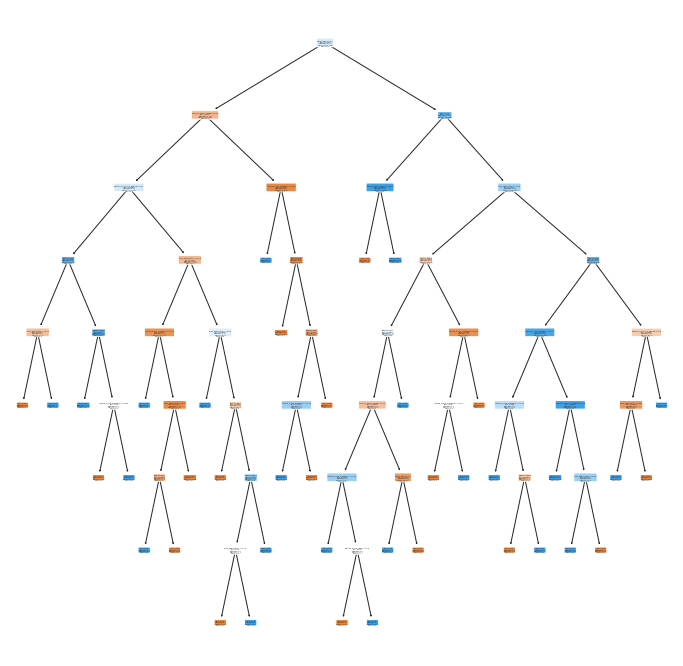

In [8]:
printTree(dectree)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 1.0
The True Positive Rate is	 1.0
The True Negative Rate is	 1.0

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7362637362637363

The True Positive Rate is	 0.7872340425531915
The True Negative Rate is	 0.6818181818181818



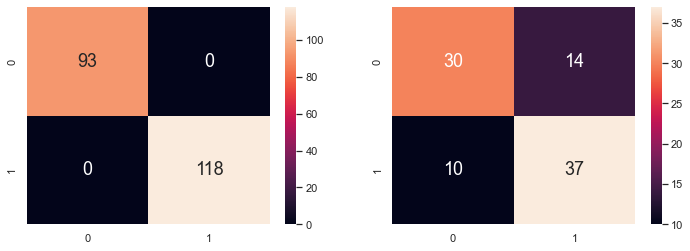

In [9]:
printCARTperformance(dectree, y_train_pred, y_test_pred)

#### 1.2.1 CART Model-1 c) Tree-Pruning: Find alpha

In [10]:
path = dectree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.         0.0035545  0.00421274 0.00440081 0.0044899  0.00458645
 0.00563115 0.00607131 0.00631912 0.00631912 0.00762807 0.00789889
 0.00858156 0.00925947 0.00926804 0.00937096 0.00987362 0.01021664
 0.01043611 0.01820336 0.02663551 0.03491118 0.06028983 0.12109236]


In [11]:
# For each alpha, we will append our model to a list
dectreeList = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    dectreeList.append(clf)

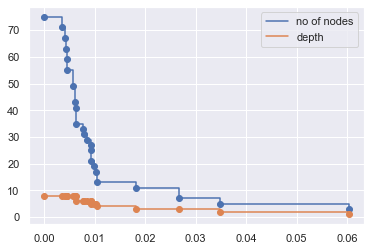

In [12]:
import matplotlib.pyplot as plt

dectreeList = dectreeList[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [dtr.tree_.node_count for dtr in dectreeList]
depth = [dtr.tree_.max_depth for dtr in dectreeList]

plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()
#As alpha increases no of nodes and depth decreases

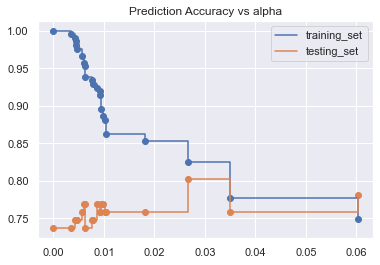

In [13]:
train_acc = []
test_acc = []
for c in dectreeList:
    y_train_pred = c.predict(X_train)
    y_test_pred = c.predict(X_test)
    train_acc.append(accuracy_score(y_train_pred,y_train))
    test_acc.append(accuracy_score(y_test_pred,y_test))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='training_set',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='testing_set',drawstyle="steps-post")
plt.legend()
plt.title('Prediction Accuracy vs alpha')
plt.show()


- The accuracy of training set and testing set is a trade-off
- We want to maximize both as much as possible -> the point between alpha 0.02 - 0.03 is spotted 
- Hence cp value 0.03 is chosen.

#### 1.2.1 CART Model-1 d) Prune Tree with Chosen CP value

In [19]:
decisiontree_ = DecisionTreeClassifier(random_state=0,ccp_alpha=0.03)
decisiontree_.fit(X_train,y_train)
y_train_pred = decisiontree_.predict(X_train)
y_test_pred = decisiontree_.predict(X_test)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8246445497630331
The True Positive Rate is	 0.9067796610169492
The True Negative Rate is	 0.7204301075268817

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.8021978021978022

The True Positive Rate is	 0.9361702127659575
The True Negative Rate is	 0.6590909090909091



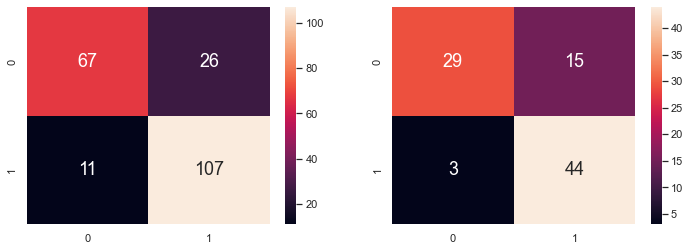

In [20]:
printCARTperformance(decisiontree_, y_train_pred, y_test_pred)

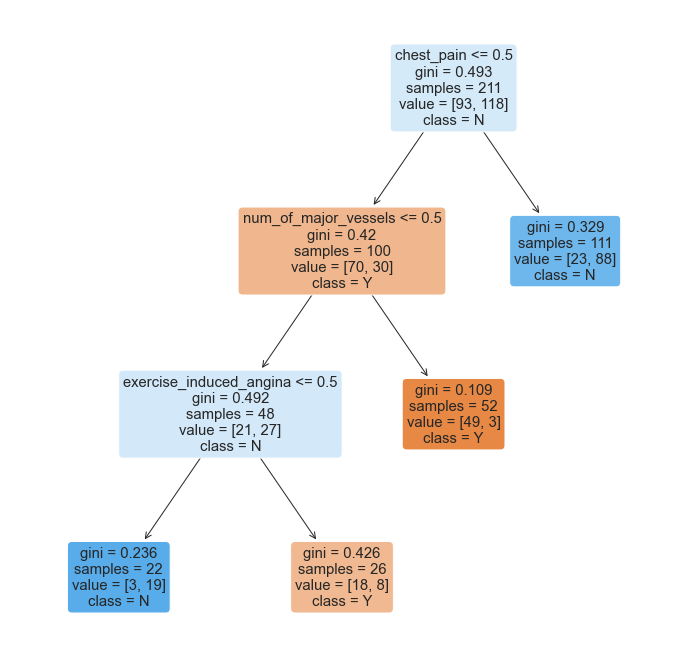

In [21]:
printTree(decisiontree_)